In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

# Statistical Data Modeling

Pandas, NumPy and SciPy provide the core functionality for building statistical models of our data. We use models to:

- Concisely **describe** the components of our data
- Provide **inference** about underlying parameters that may have generated the data
- Make **predictions** about unobserved data, or expected future observations.

This section of the tutorial illustrates how to use Python to build statistical models of low to moderate difficulty from scratch, and use them to extract estimates and associated measures of uncertainty.

Estimation
==========

An recurring statistical problem is finding estimates of the relevant parameters that correspond to the distribution that best represents our data.

In **parametric** inference, we specify *a priori* a suitable distribution, then choose the parameters that best fit the data.

* e.g. the mean $\mu$ and the variance $\sigma^2$ in the case of the normal distribution

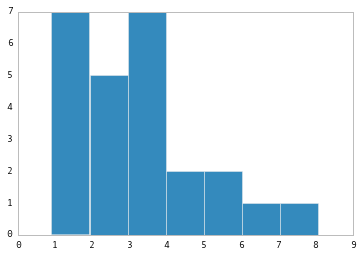

In [2]:
x = np.array([ 1.00201077,  1.58251956,  0.94515919,  6.48778002,  1.47764604,
        5.18847071,  4.21988095,  2.85971522,  3.40044437,  3.74907745,
        1.18065796,  3.74748775,  3.27328568,  3.19374927,  8.0726155 ,
        0.90326139,  2.34460034,  2.14199217,  3.27446744,  3.58872357,
        1.20611533,  2.16594393,  5.56610242,  4.66479977,  2.3573932 ])
_ = plt.hist(x, bins=7)

### Fitting data to probability distributions

We start with the problem of finding values for the parameters that provide the best fit between the model and the data, called point estimates. First, we need to define what we mean by ‘best fit’. There are two commonly used criteria:

* **Method of moments** chooses the parameters so that the sample moments (typically the sample mean and variance) match the theoretical moments of our chosen distribution.
* **Maximum likelihood** chooses the parameters to maximize the likelihood, which measures how likely it is to observe our given sample.

### Discrete Random Variables

$$X = \{0,1\}$$

$$Y = \{\ldots,-2,-1,0,1,2,\ldots\}$$

**Probability Mass Function**: 

For discrete $X$,

$$Pr(X=x) = f(x|\theta)$$

![Discrete variable](http://upload.wikimedia.org/wikipedia/commons/1/16/Poisson_pmf.svg)

***e.g. Poisson distribution***

The Poisson distribution models unbounded counts:

<div style="font-size: 150%;">  
$$Pr(X=x)=\frac{e^{-\lambda}\lambda^x}{x!}$$
</div>

* $X=\{0,1,2,\ldots\}$
* $\lambda > 0$

$$E(X) = \text{Var}(X) = \lambda$$

### Continuous Random Variables

$$X \in [0,1]$$

$$Y \in (-\infty, \infty)$$

**Probability Density Function**: 

For continuous $X$,

$$Pr(x \le X \le x + dx) = f(x|\theta)dx \, \text{ as } \, dx \rightarrow 0$$

![Continuous variable](http://upload.wikimedia.org/wikipedia/commons/e/ec/Exponential_pdf.svg)

***e.g. normal distribution***

<div style="font-size: 150%;">  
$$f(x) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{(x-\mu)^2}{2\sigma^2}\right]$$
</div>

* $X \in \mathbf{R}$
* $\mu \in \mathbf{R}$
* $\sigma>0$

$$\begin{align}E(X) &= \mu \cr
\text{Var}(X) &= \sigma^2 \end{align}$$

### Example: Nashville Precipitation

The dataset `nashville_precip.txt` contains [NOAA precipitation data for Nashville measured since 1871](http://bit.ly/nasvhville_precip_data). 

![rain](images/main.jpg)

The gamma distribution is often a good fit to aggregated rainfall data, and will be our candidate distribution in this case.

In [3]:
precip = pd.read_table("../data/nashville_precip.txt", index_col=0, na_values='NA', delim_whitespace=True)
precip.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1871,2.76,4.58,5.01,4.13,3.30,2.98,1.58,2.36,0.95,1.31,2.13,1.65
1872,2.32,2.11,3.14,5.91,3.09,5.17,6.10,1.65,4.50,1.58,2.25,2.38
1873,2.96,7.14,4.11,3.59,6.31,4.20,4.63,2.36,1.81,4.28,4.36,5.94
1874,5.22,9.23,5.36,11.84,1.49,2.87,2.65,3.52,3.12,2.63,6.12,4.19
1875,6.15,3.06,8.14,4.22,1.73,5.63,8.12,1.60,3.79,1.25,5.46,4.30


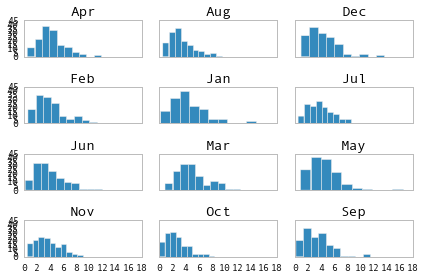

In [4]:
_ = precip.hist(sharex=True, sharey=True, grid=False)
plt.tight_layout()

The first step is recognizing what sort of distribution to fit our data to. A couple of observations:

1. The data are skewed, with a longer tail to the right than to the left
2. The data are positive-valued, since they are measuring rainfall
3. The data are continuous

There are a few possible choices, but one suitable alternative is the **gamma distribution**:

<div style="font-size: 150%;">  
$$x \sim \text{Gamma}(\alpha, \beta) = \frac{\beta^{\alpha}x^{\alpha-1}e^{-\beta x}}{\Gamma(\alpha)}$$
</div>

![gamma](http://upload.wikimedia.org/wikipedia/commons/thumb/e/e6/Gamma_distribution_pdf.svg/500px-Gamma_distribution_pdf.svg.png)

The ***method of moments*** simply assigns the empirical mean and variance to their theoretical counterparts, so that we can solve for the parameters.

So, for the gamma distribution, the mean and variance are:

<div style="font-size: 150%;">  
$$ \hat{\mu} = \bar{X} = \alpha \beta $$
$$ \hat{\sigma}^2 = S^2 = \alpha \beta^2 $$
</div>

So, if we solve for these parameters, we can use a gamma distribution to describe our data:

<div style="font-size: 150%;">  
$$ \alpha = \frac{\bar{X}^2}{S^2}, \, \beta = \frac{S^2}{\bar{X}} $$
</div>

Let's deal with the missing value in the October data. Given what we are trying to do, it is most sensible to fill in the missing value with the average of the available values. We will learn more sophisticated methods for handling missing data later in the course.

In [5]:
precip.fillna(value={'Oct': precip.Oct.mean()}, inplace=True)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1871,2.76,4.58,5.01,4.13,3.30,2.98,1.58,2.36,0.95,1.31,2.13,1.65
1872,2.32,2.11,3.14,5.91,3.09,5.17,6.10,1.65,4.50,1.58,2.25,2.38
1873,2.96,7.14,4.11,3.59,6.31,4.20,4.63,2.36,1.81,4.28,4.36,5.94
1874,5.22,9.23,5.36,11.84,1.49,2.87,2.65,3.52,3.12,2.63,6.12,4.19
1875,6.15,3.06,8.14,4.22,1.73,5.63,8.12,1.60,3.79,1.25,5.46,4.30
1876,6.41,2.22,5.28,3.62,3.40,5.65,7.15,5.77,2.52,2.68,1.26,0.95
1877,4.05,1.06,4.98,9.47,1.25,6.02,3.25,4.16,5.40,2.61,4.93,2.49
1878,3.34,2.10,3.48,6.88,2.33,3.28,9.43,5.02,1.28,2.17,3.20,6.04
1879,6.32,3.13,3.81,2.88,2.88,2.50,8.47,4.62,5.18,2.90,5.85,9.15


Now, let's calculate the sample moments of interest, the means and variances by month:

In [6]:
precip_mean = precip.mean()
precip_mean

Jan    4.523688
Feb    4.097801
Mar    4.977589
Apr    4.204468
May    4.325674
Jun    3.873475
Jul    3.895461
Aug    3.367305
Sep    3.377660
Oct    2.610500
Nov    3.685887
Dec    4.176241
dtype: float64

In [7]:
precip_var = precip.var()
precip_var

Jan    6.928862
Feb    5.516660
Mar    5.365444
Apr    4.117096
May    5.306409
Jun    5.033206
Jul    3.777012
Aug    3.779876
Sep    4.940099
Oct    2.741659
Nov    3.679274
Dec    5.418022
dtype: float64

We then use these moments to estimate $\alpha$ and $\beta$ for each month:

In [8]:
alpha_mom = precip_mean ** 2 / precip_var
beta_mom = precip_var / precip_mean

In [9]:
alpha_mom, beta_mom

(Jan    2.953407
 Feb    3.043866
 Mar    4.617770
 Apr    4.293694
 May    3.526199
 Jun    2.980965
 Jul    4.017624
 Aug    2.999766
 Sep    2.309383
 Oct    2.485616
 Nov    3.692511
 Dec    3.219070
 dtype: float64, Jan    1.531684
 Feb    1.346249
 Mar    1.077920
 Apr    0.979219
 May    1.226724
 Jun    1.299403
 Jul    0.969593
 Aug    1.122522
 Sep    1.462581
 Oct    1.050243
 Nov    0.998206
 Dec    1.297344
 dtype: float64)

We can use the `gamma.pdf` function in `scipy.stats.distributions` to plot the ditribtuions implied by the calculated alphas and betas. For example, here is January:

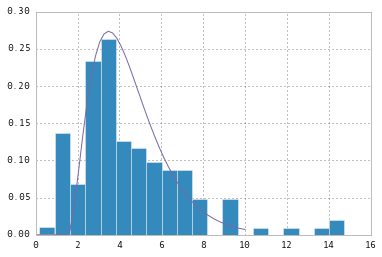

In [10]:
from scipy.stats.distributions import gamma

precip.Jan.hist(normed=True, bins=20)
plt.plot(np.linspace(0, 10), gamma.pdf(np.linspace(0, 10), alpha_mom[0], beta_mom[0]))

Looping over all months, we can create a grid of plots for the distribution of rainfall, using the gamma distribution:

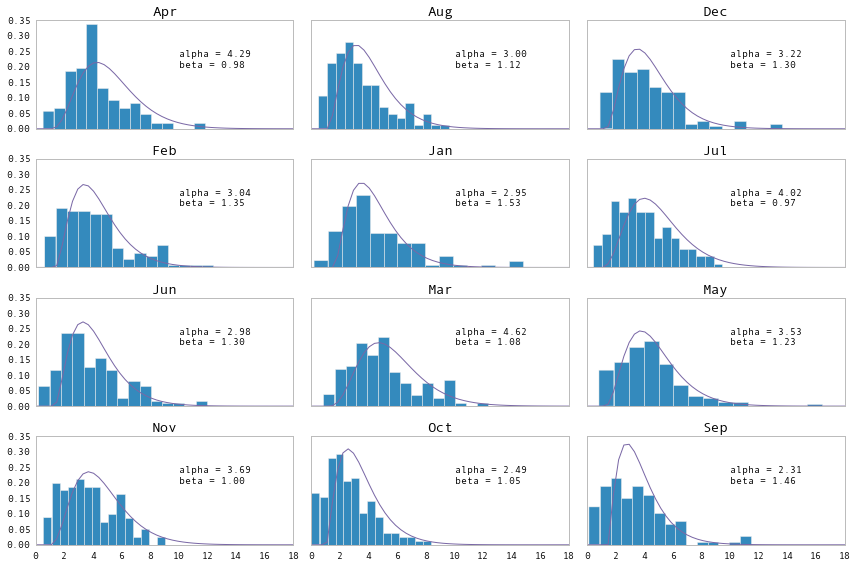

In [11]:
axs = precip.hist(normed=True, figsize=(12, 8), sharex=True, sharey=True, bins=15, grid=False)

for ax in axs.ravel():
    
    # Get month
    m = ax.get_title()
    
    # Plot fitted distribution
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, gamma.pdf(x, alpha_mom[m], beta_mom[m]))
    
    # Annotate with parameter estimates
    label = 'alpha = {0:.2f}\nbeta = {1:.2f}'.format(alpha_mom[m], beta_mom[m])
    ax.annotate(label, xy=(10, 0.2))
    
plt.tight_layout()

Maximum Likelihood
==================

**Maximum likelihood** (ML) fitting is usually more work than the method of moments, but it is preferred as the resulting estimator is known to have good theoretical properties. 

There is a ton of theory regarding ML. We will restrict ourselves to the mechanics here.

Say we have some data $y = y_1,y_2,\ldots,y_n$ that is distributed according to some distribution:

<div style="font-size: 120%;">  
$$Pr(Y_i=y_i | \theta)$$
</div>

Here, for example, is a **Poisson distribution** that describes the distribution of some discrete variables, typically *counts*: 

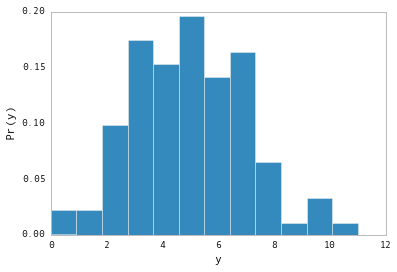

In [12]:
y = np.random.poisson(5, size=100)
plt.hist(y, bins=12, normed=True)
plt.xlabel('y'); plt.ylabel('Pr(y)')

The product $\prod_{i=1}^n Pr(y_i | \theta)$ gives us a measure of how **likely** it is to observe values $y_1,\ldots,y_n$ given the parameters $\theta$. Maximum likelihood fitting consists of choosing the appropriate function $l= Pr(Y|\theta)$ to maximize for a given set of observations. We call this function the *likelihood function*, because it is a measure of how likely the observations are if the model is true.

> Given these data, how likely is this model?

In the above model, the data were drawn from a Poisson distribution with parameter $\lambda =5$.

$$L(y|\lambda=5) = \frac{e^{-5} 5^y}{y!}$$

So, for any given value of $y$, we can calculate its likelihood:

In [13]:
poisson_like = lambda x, lam: np.exp(-lam) * (lam**x) / (np.arange(x)+1).prod()

lam = 6
value = 10
poisson_like(value, lam)

0.041303093412337726

In [14]:
np.sum(poisson_like(yi, lam) for yi in y)

11.617253456002866

In [15]:
lam = 8
np.sum(poisson_like(yi, lam) for yi in y)

8.024233516810094

We can plot the likelihood function for any value of the parameter(s):

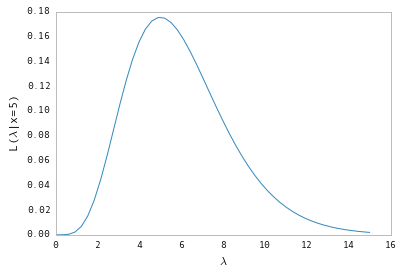

In [16]:
lambdas = np.linspace(0,15)
x = 5
plt.plot(lambdas, [poisson_like(x, l) for l in lambdas])
plt.xlabel('$\lambda$')
plt.ylabel('L($\lambda$|x={0})'.format(x))

How is the likelihood function different than the probability distribution function (PDF)? The likelihood is a function of the parameter(s) *given the data*, whereas the PDF returns the probability of data given a particular parameter value. Here is the PDF of the Poisson for $\lambda=5$.

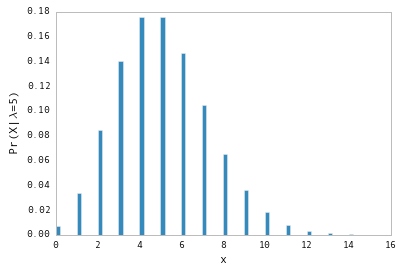

In [17]:
lam = 5
xvals = np.arange(15)
plt.bar(xvals, [poisson_like(x, lam) for x in xvals], width=0.2)
plt.xlabel('x')
plt.ylabel('Pr(X|$\lambda$=5)')

*Why are we interested in the likelihood function?*

A reasonable estimate of the true, unknown value for the parameter is one which **maximizes the likelihood function**. So, inference is reduced to an optimization problem.

Going back to the rainfall data, if we are using a gamma distribution we need to maximize:

$$\begin{align}l(\alpha,\beta) &= \sum_{i=1}^n \log[\beta^{\alpha} x^{\alpha-1} e^{-x/\beta}\Gamma(\alpha)^{-1}] \cr 
&= n[(\alpha-1)\overline{\log(x)} - \bar{x}\beta + \alpha\log(\beta) - \log\Gamma(\alpha)]\end{align}$$

(*Its usually easier to work in the log scale*)

where $n = 2012 − 1871 = 141$ and the bar indicates an average over all *i*. We choose $\alpha$ and $\beta$ to maximize $l(\alpha,\beta)$.

Notice $l$ is infinite if any $x$ is zero. We do not have any zeros, but we do have an NA value for one of the October data, which we dealt with above.

### Finding the MLE

To find the maximum of any function, we typically take the *derivative* with respect to the variable to be maximized, set it to zero and solve for that variable. 

$$\frac{\partial l(\alpha,\beta)}{\partial \beta} = n\left(\frac{\alpha}{\beta} - \bar{x}\right) = 0$$

Which can be solved as $\beta = \alpha/\bar{x}$. However, plugging this into the derivative with respect to $\alpha$ yields:

$$\frac{\partial l(\alpha,\beta)}{\partial \alpha} = \log(\alpha) + \overline{\log(x)} - \log(\bar{x}) - \frac{\Gamma(\alpha)'}{\Gamma(\alpha)} = 0$$

This has no closed form solution. We must use ***numerical optimization***!

Numerical optimization alogarithms take an initial "guess" at the solution, and iteratively improve the guess until it gets "close enough" to the answer.

Here, we will use Newton-Raphson algorithm:

<div style="font-size: 120%;">  
$$x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}$$
</div>

Which is available to us via SciPy:

In [18]:
from scipy.optimize import newton

Here is a graphical example of how Newton-Raphson converges on a solution, using an arbitrary function:

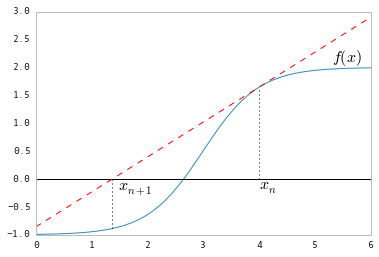

In [19]:
%run newton_raphson_plot.py

To apply the Newton-Raphson algorithm, we need a function that returns a vector containing the **first and second derivatives** of the function with respect to the variable of interest. The second derivative of the gamma distribution with respect to $\alpha$ is:

$$\frac{\partial^2 l(\alpha,\beta)}{\partial \alpha^2} = \frac{1}{\alpha} - \frac{\partial}{\partial \alpha} \left[ \frac{\Gamma(\alpha)'}{\Gamma(\alpha)} \right]$$

In [20]:
from scipy.special import psi, polygamma

dlgamma = lambda a, log_mean, mean_log: np.log(a) - psi(a) - log_mean + mean_log
dl2gamma = lambda a, *args: 1./a - polygamma(1, a)

where `log_mean` and `mean_log` are $\log{\bar{x}}$ and $\overline{\log(x)}$, respectively. `psi` and `polygamma` are complex functions of the Gamma function that result when you take first and second derivatives of that function.

In [21]:
# Calculate statistics
log_mean = precip.mean().apply(np.log)
mean_log = precip.apply(np.log).mean()

Time to optimize!

In [22]:
# Alpha MLE for December
alpha_mle = newton(dlgamma, 2, dl2gamma, args=(log_mean[-1], mean_log[-1]))
alpha_mle

3.5189679152399647

And now plug this back into the solution for beta:

<div style="font-size: 120%;">  
$$ \beta  = \frac{\alpha}{\bar{X}} $$
</div>

In [23]:
beta_mle = alpha_mle/precip.mean()[-1]
beta_mle

0.84261607548413797

We can compare the fit of the estimates derived from MLE to those from the method of moments:

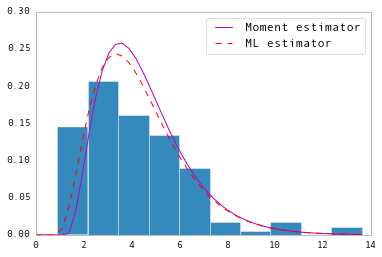

In [24]:
dec = precip.Dec
dec.hist(normed=True, bins=10, grid=False)
x = np.linspace(0, dec.max())
plt.plot(x, gamma.pdf(x, alpha_mom[-1], beta_mom[-1]), 'm-', label='Moment estimator')
plt.plot(x, gamma.pdf(x, alpha_mle, beta_mle), 'r--', label='ML estimator')
plt.legend()

For some common distributions, SciPy includes methods for fitting via MLE:

In [25]:
from scipy.stats import gamma

gamma.fit(precip.Dec)

(2.2427517753152308, 0.65494604470188622, 1.570073932063466)

This fit is not directly comparable to our estimates, however, because SciPy's `gamma.fit` method fits an odd 3-parameter version of the gamma distribution.

### Model checking

An informal way of checking the fit of our parametric model is to compare the observed quantiles of the data to those of the theoretical model we are fitting it to. If the model is a good fit, the points should fall on a 45-degree reference line. This is called a **probability plot**.

SciPy includes a `probplot` function that generates probability plots based on the data and a specified distribution.

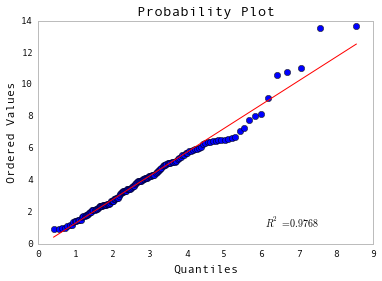

In [94]:
from scipy.stats import probplot

probplot(precip.Dec, dist=gamma(3.51, scale=0.84), plot=plt);

### Example: truncated distribution

Suppose that we observe $Y$ truncated below at $a$ (where $a$ is known). If $X$ is the distribution of our observation, then:

$$ P(X \le x) = P(Y \le x|Y \gt a) = \frac{P(a \lt Y \le x)}{P(Y \gt a)}$$

(so, $Y$ is the original variable and $X$ is the truncated variable) 

Then X has the density:

$$f_X(x) = \frac{f_Y (x)}{1−F_Y (a)} \, \text{for} \, x \gt a$$ 

Suppose $Y \sim N(\mu, \sigma^2)$ and $x_1,\ldots,x_n$ are independent observations of $X$. We can use maximum likelihood to find $\mu$ and $\sigma$. 

First, we can simulate a truncated distribution using a `while` statement to eliminate samples that are outside the support of the truncated distribution.

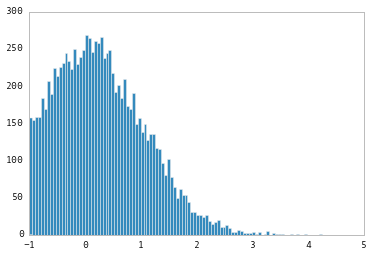

In [26]:
x = np.random.normal(size=10000)

# Truncation point
a = -1

# Resample until all points meet criterion
x_small = x < a
while x_small.sum():
    x[x_small] = np.random.normal(size=x_small.sum())
    x_small = x < a
    
_ = plt.hist(x, bins=100)

We can construct a log likelihood for this function using the conditional form:

$$f_X(x) = \frac{f_Y (x)}{1−F_Y (a)} \, \text{for} \, x \gt a$$ 

The denominator normalizes the truncated distribution so that it integrates to one.

In [27]:
from scipy.stats.distributions import norm

trunc_norm = lambda theta, a, x: -(np.log(norm.pdf(x, theta[0], theta[1])) - 
                                      np.log(1 - norm.cdf(a, theta[0], theta[1]))).sum()

For this example, we will use another optimization algorithm, the **Nelder-Mead simplex algorithm**. It has a couple of advantages: 

- it does not require derivatives
- it can optimize (minimize) a vector of parameters

SciPy implements this algorithm in its `fmin` function:

In [28]:
from scipy.optimize import fmin

fmin(trunc_norm, np.array([1,2]), args=(-1, x))

Optimization terminated successfully.
         Current function value: 10996.433887
         Iterations: 41
         Function evaluations: 80


array([ 0.02979311,  0.9813702 ])

In general, simulating data is a terrific way of testing your model before using it with real data.

## Kernel density estimates

In some instances, we may not be interested in the parameters of a particular distribution of data, but just a smoothed representation of the data at hand. In this case, we can estimate the disribution *non-parametrically* (i.e. making no assumptions about the form of the underlying distribution) using kernel density estimation.

In [58]:
# Some random data
y = np.random.normal(10, size=15)
y

array([ 10.32616967,  10.03169785,   9.45926269,   9.787085  ,
        10.19417931,   8.75587926,   8.21473945,  10.8555982 ,
        10.41826686,  10.13738678,  11.08367366,   9.84169284,
         9.49015527,  11.62210792,  10.91681776])

The kernel estimator is a sum of symmetric densities centered at each observation. The selected kernel function determines the shape of each component while the **bandwidth** determines their spread. For example, if we use a Gaussian kernel function, the variance acts as the bandwidth.

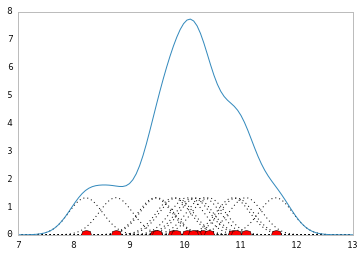

In [61]:
x = np.linspace(7, 13, 100)
# Smoothing parameter
s = 0.3
# Calculate the kernels
kernels = np.transpose([norm.pdf(x, yi, s) for yi in y])
plt.plot(x, kernels, 'k:')
plt.plot(x, kernels.sum(1))
plt.plot(y, np.zeros(len(y)), 'ro', ms=10)

SciPy implements a Gaussian KDE that automatically chooses an appropriate bandwidth. Let's create a bi-modal distribution of data that is not easily summarized by a parametric distribution:

In [62]:
# Create a bi-modal distribution with a mixture of Normals.
x1 = np.random.normal(0, 2, 50)
x2 = np.random.normal(5, 1, 50)

# Append by row
x = np.r_[x1, x2]

(array([ 0.00857567,  0.00857567,  0.04287835,  0.12863505,  0.12005938,
         0.06860536,  0.04287835,  0.12863505,  0.20581608,  0.10290804]),
 array([-4.7343771 , -3.56828748, -2.40219786, -1.23610824, -0.07001862,
         1.096071  ,  2.26216061,  3.42825023,  4.59433985,  5.76042947,
         6.92651909]),
 <a list of 10 Patch objects>)

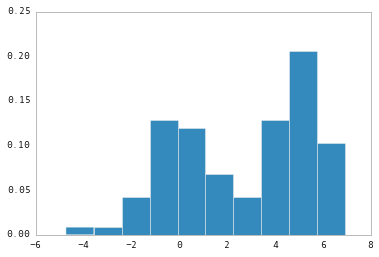

In [63]:
plt.hist(x, bins=10, normed=True)

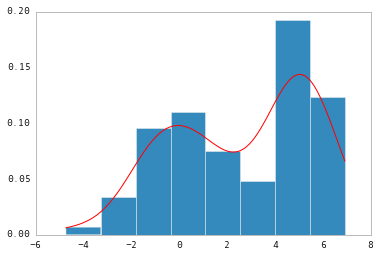

In [64]:
from scipy.stats import kde

density = kde.gaussian_kde(x)
xgrid = np.linspace(x.min(), x.max(), 100)
plt.hist(x, bins=8, normed=True)
plt.plot(xgrid, density(xgrid), 'r-')

### Exercise: Comparative Chopstick Effectiveness

A few researchers set out to determine what the optimal length for chopsticks is. The dataset `chopstick-effectiveness.csv` includes measurements of "Food Pinching Efficiency" across a range of chopstick lengths for 31 individuals.

Use the method of moments or MLE to calculate the mean and variance of food pinching efficiency for each chopstick length. This means you need to select an appropriate distributional form for this data.

In [ ]:
# Write your answer here